In this cycle we:



# 1 IMPORTS

In [1]:
import re
import inflection
import numpy                                          as np
import pandas                                         as pd
import sweetviz                                       as sv
import seaborn                                        as sns
import umap.umap_                                     as umap
import matplotlib.cm                                  as cm
import matplotlib.pyplot                              as plt
            
from plotly              import express               as px
from sklearn             import cluster               as c
from sklearn             import metrics               as m
from sklearn             import mixture               as mx
from IPython.display     import Image      
from sklearn             import ensemble              as en
from sklearn             import manifold              as mn
from sklearn             import decomposition         as dd
from sklearn             import preprocessing         as pp
from scipy.cluster       import hierarchy             as hc
from pandas_profiling    import ProfileReport
from sklearn.neighbors   import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer 
from yellowbrick.cluster import SilhouetteVisualizer

import warnings
warnings.filterwarnings('ignore')

## 1.1 Definitions 

In [2]:
# Set Seaborn configurations
sns.set_palette('tab10')
sns.set_style('darkgrid')

# Standard font for plots
def std_font(ax1, title, xlabel, ylabel):
    ax1.set_title(title, loc='left', fontdict={'fontsize': 18}, pad=20)
    ax1.set_xlabel(xlabel, fontdict={'fontsize': 12, 'style': 'italic'})
    ax1.set_ylabel(ylabel, fontdict={'fontsize': 12, 'style': 'italic'})
    return None

## 1.2 Loading Data

In [3]:
df_raw = pd.read_csv('../data/ecommerce.csv', parse_dates=['InvoiceDate'])
# Renaming columns
cols_snake = list( map( lambda x: inflection.underscore( x ), df_raw.columns ) )
df_raw.columns = cols_snake

# 2 DATA DESCRIPTION

## 2.1 Data Preview

In [4]:
df_raw.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850.0,United Kingdom


## 2.2 Data Format and Types

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      541909 non-null  int64         
 4   invoice_date  541909 non-null  datetime64[ns]
 5   unit_price    541909 non-null  float64       
 6   customer_id   406829 non-null  float64       
 7   country       541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## 2.3 NA Checking and Treatment

In [6]:
df_raw.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 2.3.1 Treating Missing Values

In [7]:
# adding 'No description' to missing discription
df_raw['description'].fillna(value='NO DESCRIPTION', inplace=True)

# deleting NAs customer_id (this removed about 25% of our database)
# df_raw.dropna(subset=['customer_id'], inplace=True)

# creating customers_id
df_missing = df_raw.loc[df_raw['customer_id'].isna(), :]
df_not_missing = df_raw.loc[~df_raw['customer_id'].isna(), :]

df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

# merge original with reference dataframe
df_raw = pd.merge( df_raw, df_backup, on='invoice_no', how='left' )

# coalesce 
df_raw['customer_id'] = df_raw['customer_id_x'].combine_first( df_raw['customer_id_y'] )

# drop extra columns
df_raw = df_raw.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )



In [8]:
df_raw.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

## 2.4 Changing types

In [9]:
df_raw['customer_id'] = df_raw['customer_id'].astype( int )

## 2.5 Discriptive Statistics

In [10]:
df_clean = df_raw.copy()

### 2.5.1 Numerical Attributes

Important findings:

- We found a huge negative value in quantitiy (that can be due to product return, or cancelled purchase)
- We found a zero minimum price (what is the root cause of this? promotions? coupons?)
- We found a lot of negative values in quantity

In [11]:
num_att = df_clean.select_dtypes(['int64', 'float64', 'int'])

In [12]:
# getting skew
skew = pd.DataFrame(num_att.apply(lambda x: x.skew())).round(2).T
skew.rename(index={0: 'skew'}, inplace=True)

# getting kurtosis
kurtosis = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).round(2).T
kurtosis.rename(index={0: 'kurtosis'}, inplace=True)

# numerical features 
describe = num_att.describe().round(2)
ma = pd.concat([describe, skew, kurtosis], axis=0)
ma

,quantity,unit_price,customer_id
count,541909.00,541909.00,541909.00
mean,9.55,4.61,16688.84
std,218.08,96.76,2911.41
min,-80995.00,-11062.06,12346.00
25%,1.00,1.25,14367.00
50%,3.00,2.08,16249.00
75%,10.00,4.13,18283.00
max,80995.00,38970.00,22709.00
skew,-0.26,186.51,0.49
kurtosis,119769.16,59005.72,-0.80


### 2.5.2 Categorical Attributes

In [13]:
cat_att = df_clean.select_dtypes(['object'])

In [14]:
cat_att.apply( lambda x: x.unique().shape[0] )

invoice_no     25900
stock_code      4070
description     4224
country           38
dtype: int64

In [15]:
df_letter_invoices = df_clean.loc[df_clean['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


# 3 DATAFRAME FILTERING

In [16]:
# =========================================================================================
# Check if its worth to treat the invoice_no and stock_code with letters in the values
# =========================================================================================

# # invoice_no
# df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
# df_letter_invoices.head()

# print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
# print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

# # stock_code
# # check stock codes only characters
# df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()


## 3.1 Line Filtering

In [17]:
# filtering zero values in unit_price (WE WILL CONSIDER THESE ITEMS AS PROMO OR ERROR)
df_clean.query('unit_price >= 0.04 ', inplace=True)

# bad users (apresentam padroes de compra bastante desconexo, poluindo nosso modelo)
df_clean = df_clean[~df_clean['customer_id'].isin( [16446] )]

# Considering negative quantities as devolutions and positive quantities as real purchases
df_clean_returns = df_clean.query('quantity < 0')
df_clean = df_clean.query('quantity >=0')

# removing stock codes that does not represent puchases
df_clean = df_clean[~df_clean['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'] )]

# removing innacurate country information 
df_clean = df_clean[~df_clean['country'].isin( ['European Community', 'Unspecified' ] ) ]

## 3.2 Column Selection

# 4 QUESTIONS & HYPOTHESIS

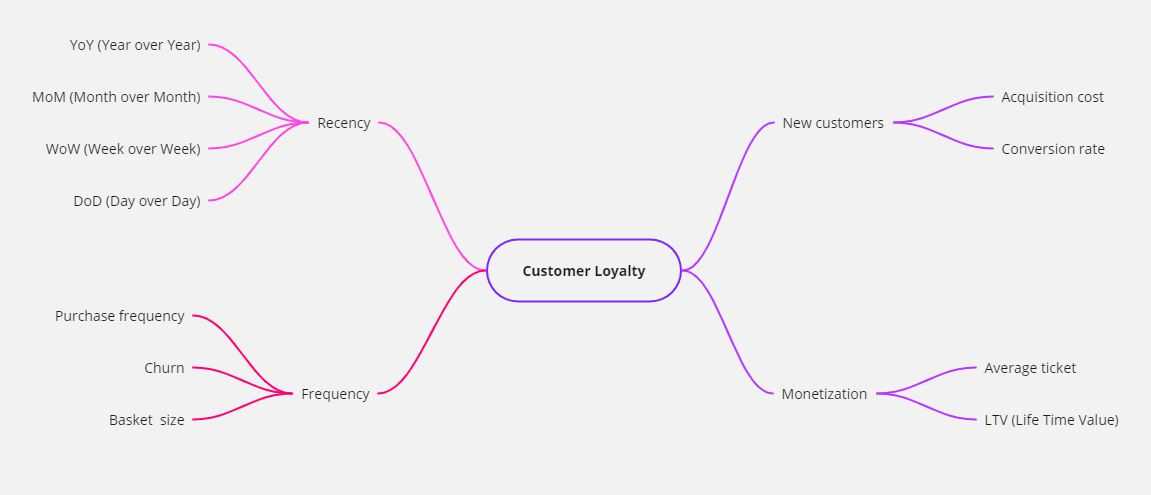

In [18]:
Image( '../images/mindmap.JPG' )

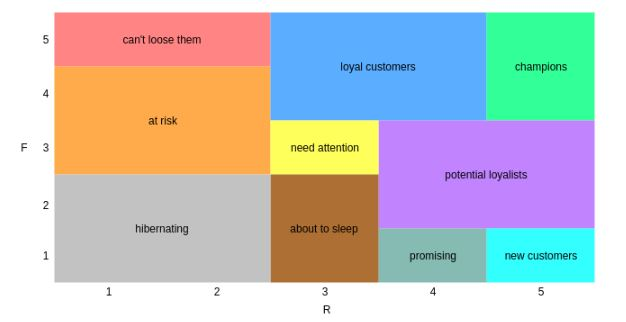

In [19]:
Image( '../images/rfm.JPG' )

Picture - https://medium.com/codex/crm-analytics-rfm-analysis-90aa2ae55fbc

**1.** 

**2.** 

**3.** 

**4.** 

**5.** 

**6.** 

**7.** 

**8.** 

# 5 FEATURE ENGINEERING

In [20]:
# ====================
# CREATING RFM TABLE
# ====================

# initiating df_rfm table with customers IDs
df_rfm = df_clean.drop( ['invoice_no', 'stock_code', 'description', 
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1 ).drop_duplicates( ignore_index=True )

In [21]:
# monetary
df_clean['gross_revenue'] = df_clean['quantity'] * df_clean['unit_price']
df_monetary = df_clean[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_rfm = pd.merge( df_rfm, df_monetary, on='customer_id', how='left' )


In [22]:
# recency - last purchase
df_recency = df_clean[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df_clean['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_rfm = pd.merge( df_rfm, df_recency, on='customer_id', how='left' )

In [23]:
# amount of purchases
df_freq = df_clean[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index().rename( columns={'invoice_no': 'amount_invoices'})
df_rfm = pd.merge( df_rfm, df_freq, on='customer_id', how='left' )

In [24]:
# amount of purchased items
df_prod = df_clean[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity': 'amount_items'})
df_rfm = pd.merge( df_rfm, df_prod, on='customer_id', how='left' )


In [25]:
# amount of purchased products
# Numero de produtos
df_freq = (df_clean.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'amount_products'} ) )
df_rfm = pd.merge( df_rfm, df_freq, on='customer_id', how='left' )


In [26]:
# average ticket
df_avg_ticket = df_clean[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_rfm = pd.merge( df_rfm, df_avg_ticket, on='customer_id', how='left')

In [27]:
# number of returns
df_number_returns = df_clean_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'amount_returns'})
df_number_returns['amount_returns'] = df_number_returns['amount_returns'] * -1
df_rfm = pd.merge( df_rfm, df_number_returns, on='customer_id', how='left')
df_rfm.loc[df_rfm['amount_returns'].isna(), 'amount_returns'] = 0
# df_rfm['amount_returns'].fillna(value=0, inplace=True)

In [28]:
# Average recency days
df_aux = df_clean[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[False, False] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date
df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )
df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

df_rfm = pd.merge( df_rfm, df_avg_recency_days, on='customer_id', how='left' )


In [29]:
# frequency purchase 
df_aux = ( df_clean[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()

df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )
df_rfm = pd.merge( df_rfm, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

In [30]:
# basket size (Units by basket)
df_aux = ( df_clean.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_rfm = pd.merge( df_rfm, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )

In [31]:
df_aux = ( df_clean.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_rfm = pd.merge( df_rfm, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )

In [32]:
df_rfm.isna().sum()

customer_id                  0
gross_revenue                0
recency_days                 0
amount_invoices              0
amount_items                 0
amount_products              0
avg_ticket                   0
amount_returns               0
avg_recency_days          2922
frequency                    0
avg_basket_size              0
avg_unique_basket_size       0
dtype: int64

In [33]:
df_rfm.head()

,customer_id,gross_revenue,recency_days,amount_invoices,amount_items,amount_products,avg_ticket,amount_returns,avg_recency_days,frequency,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372,34,1733,297,18.152222,40.0,-1.000000,17.000000,50.970588,0.617647
1,13047,3232.59,56,9,1390,171,18.904035,36.0,-52.833333,0.028302,154.444444,11.666667
2,12583,6705.38,2,15,5028,232,28.902500,51.0,-26.500000,0.040323,335.200000,7.600000
3,13748,948.25,95,5,439,28,33.866071,0.0,-92.666667,0.017921,87.800000,4.800000
4,15100,876.00,333,3,80,3,292.000000,22.0,-20.000000,0.073171,26.666667,0.333333


# 6 STATISTICAL ANALYSIS

In [34]:
df_rfm.dropna(inplace=True)

## 6.1 Univariate Analysis

In [35]:
profile = ProfileReport( df_rfm )
profile.to_file( 'profile_report.html' )

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
# report = sv.analyze(df_rfm)
# report.show_html('sweetviz_report.html')

# 7 FEATURE SELECTION

In [37]:
df_rfm_raw = df_rfm.copy()
selected_cols = ['customer_id', 'gross_revenue', 'recency_days', 'amount_products', 'frequency', 'amount_returns']
df_rfm = df_rfm[selected_cols].copy()

# 8 DATA PREPARATION

## 8.1 Normalization

In [38]:
## Standard Scalaer
mm = pp.MinMaxScaler()

# df_rfm['gross_revenue'] = ss.fit_transform( df_rfm[['gross_revenue']] )
# df_rfm['recency_days'] = ss.fit_transform( df_rfm[['recency_days']] )
# # df_rfm['invoice_no'] = ss.fit_transform( df_rfm[['invoice_no']] )
# df_rfm['avg_ticket'] = ss.fit_transform( df_rfm[['avg_ticket']] )
# # df_rfm['returns'] = ss.fit_transform( df_rfm[['returns']] )

df_rfm['gross_revenue'] = mm.fit_transform( df_rfm[['gross_revenue']] )
df_rfm['recency_days']           = mm.fit_transform( df_rfm[['recency_days']] )
# df_rfm['amount_invoices']          = mm.fit_transform( df_rfm[['amount_invoices']])
# df_rfm['amount_items']             = mm.fit_transform( df_rfm[['amount_items']])
df_rfm['amount_products']          = mm.fit_transform( df_rfm[['amount_products']])
# df_rfm['avg_ticket']             = mm.fit_transform( df_rfm[['avg_ticket']])
# df_rfm['avg_recency_days']       = mm.fit_transform( df_rfm[['avg_recency_days']])
df_rfm['frequency']              = mm.fit_transform( df_rfm[['frequency']])
df_rfm['amount_returns']           = mm.fit_transform( df_rfm[['amount_returns']])
# df_rfm['avg_basket_size']        = mm.fit_transform( df_rfm[['avg_basket_size']])
# df_rfm['avg_unique_basket_size'] = mm.fit_transform( df_rfm[['avg_unique_basket_size']] )

In [39]:
X = df_rfm.drop(columns=['customer_id']).copy()
X.head()

,gross_revenue,recency_days,amount_products,frequency,amount_returns
0,0.019185,1.000000,0.037647,1.000000,0.004438
1,0.011451,0.150538,0.021567,0.001345,0.003994
2,0.023894,0.005376,0.029352,0.002052,0.005658
3,0.003267,0.255376,0.003318,0.000734,0.000000
4,0.003008,0.895161,0.000128,0.003985,0.002441


## 8.2 Space Study

### 8.2.1 PCA

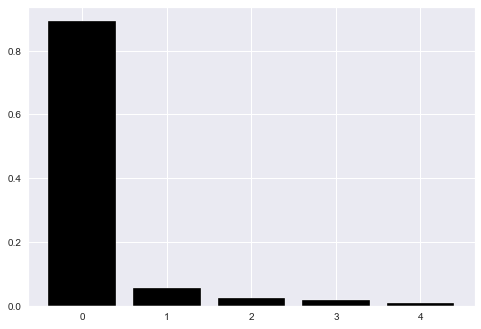

In [40]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

<AxesSubplot:xlabel='0', ylabel='1'>

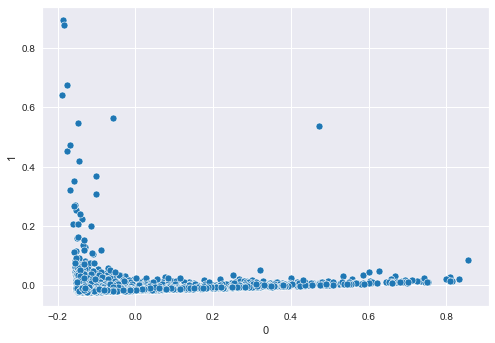

In [41]:
sns.scatterplot( x=0, y=1, data=df_pca )

### 8.2.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

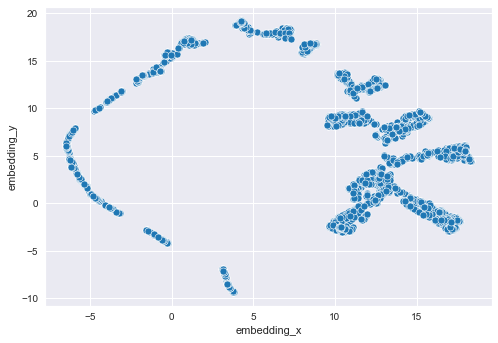

In [42]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

### 8.2.3 t-SNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

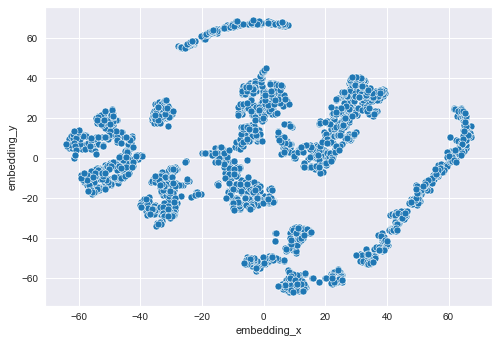

In [43]:
reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

### 8.2.4 TREE Based Embedding

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

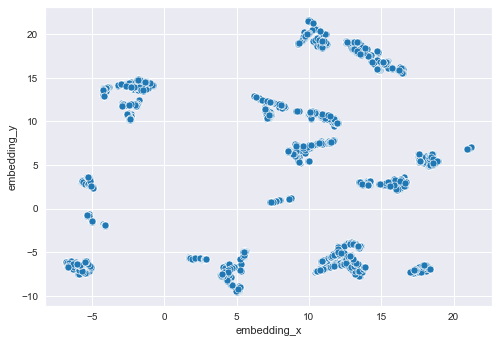

In [44]:
# training dataset
X = df_rfm.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df_rfm['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf 

# dataframe Leaf

df_leaf = pd.DataFrame( rf_model.apply( X ) )

# Reduzer dimensionality
reducer = umap.UMAP(n_components=2, random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree )

# 9 HYPERPARAMETER FINE TUNNING

In [45]:
# clusters = [2, 3, 4, 5, 6, 7]
clusters = np.arange(2,31,1)
# X = df_rfm.drop( columns=['customer_id'] ) # no espaco original dos dados
X = df_tree.copy() # no espaco transformado

## 9.1 KMEANS

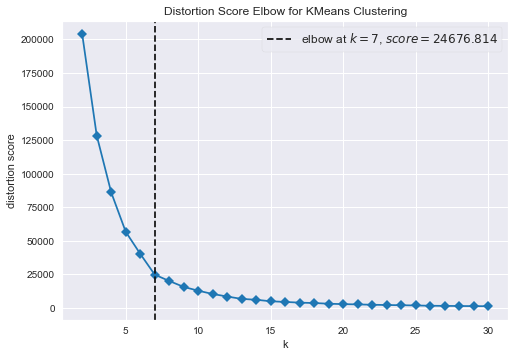

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [46]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
kmeans.fit( X )
kmeans.show()

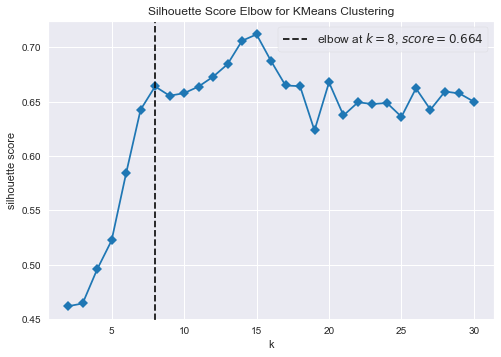

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [47]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show()

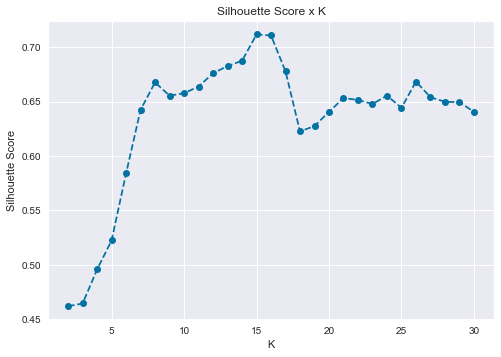

In [48]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

IndexError: index 3 is out of bounds for axis 0 with size 3

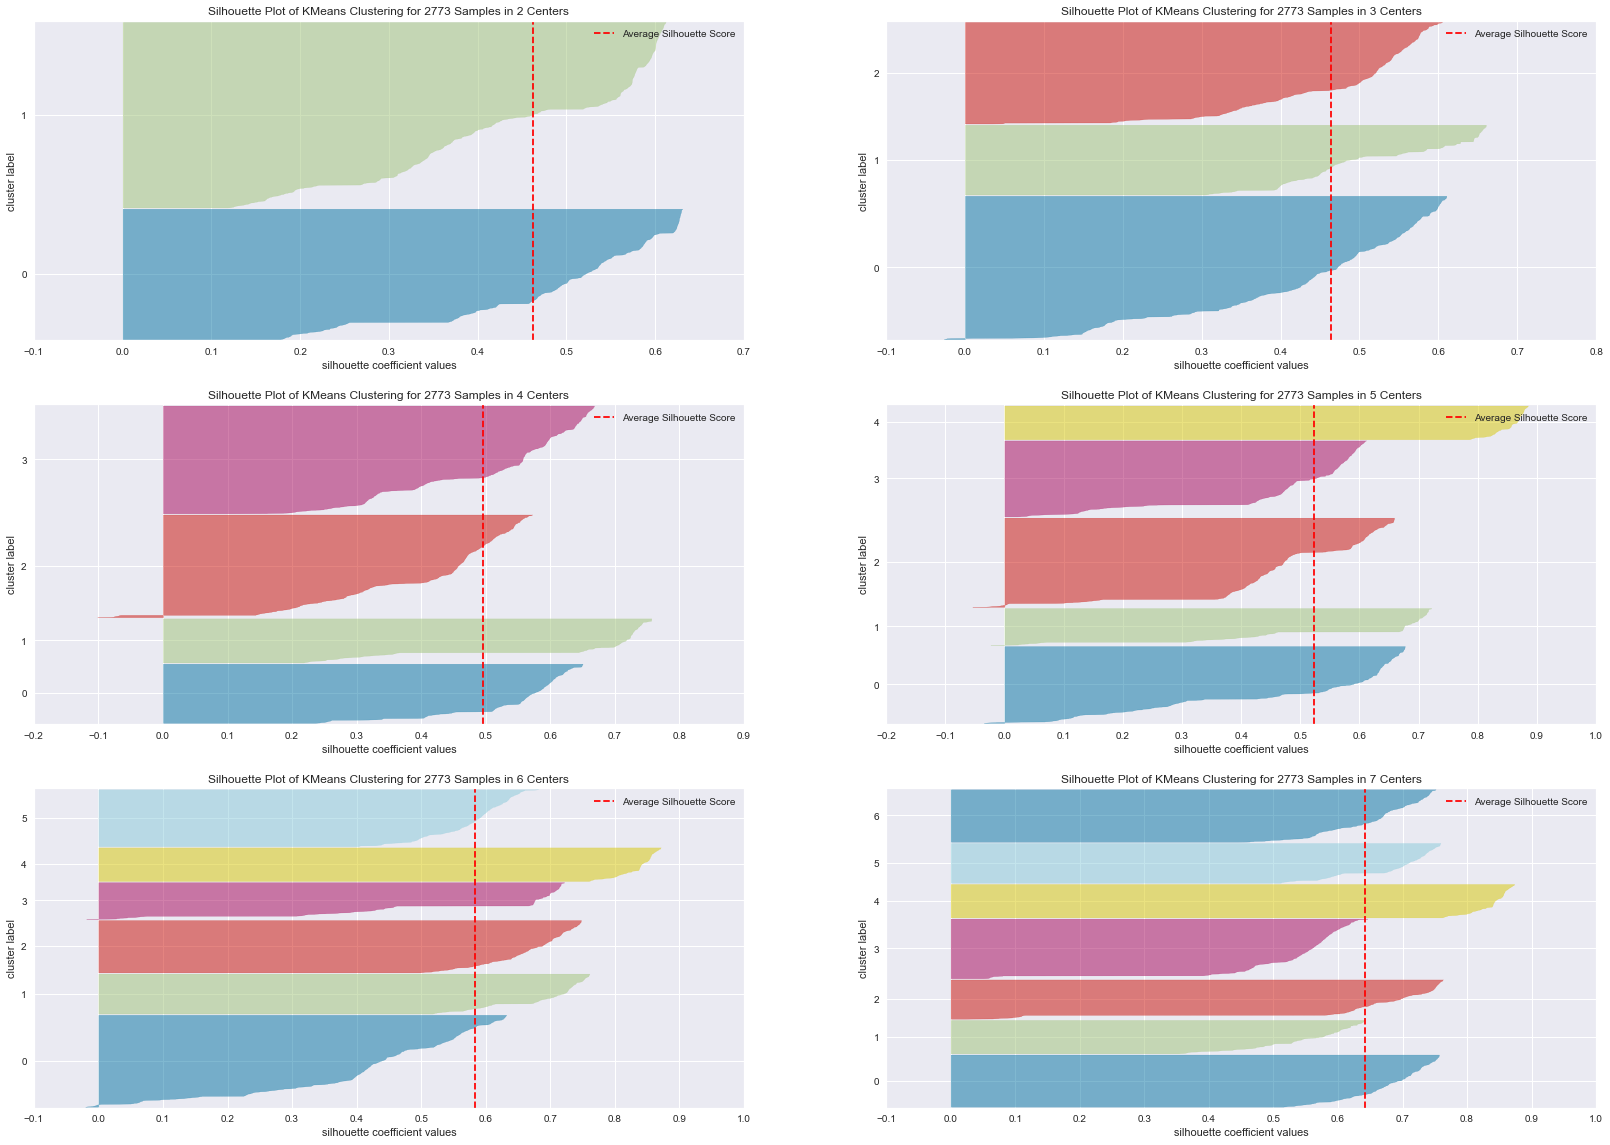

In [49]:
fig, ax = plt.subplots( 3, 2, figsize=(28, 20) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

## 9.2 GMM

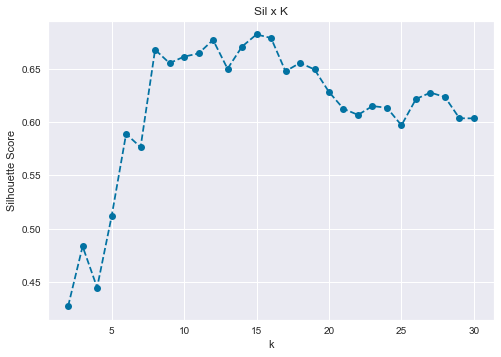

In [50]:
# AIC - Ajuste dos dados
# BIC - ajuste dos parametros

gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k, random_state=42 )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## 9.3 Hierarchical Clustering

[]

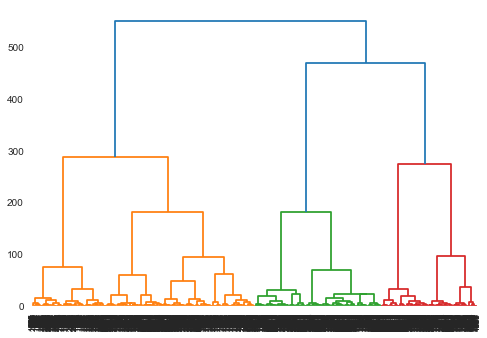

In [51]:
# model definition and training
hc_model = hc.linkage( X, 'ward' )

hc.dendrogram( 
    hc_model, 
    leaf_rotation=90,
    leaf_font_size=8
)

plt.plot()

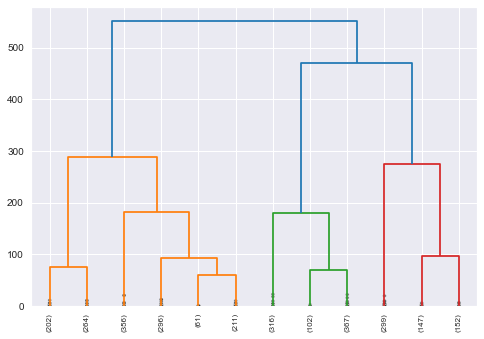

In [52]:
hc.dendrogram( 
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True
)

plt.show()

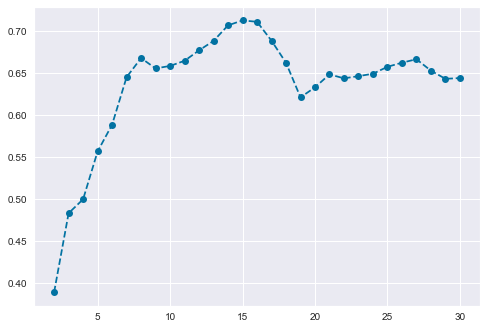

In [53]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

## 9.4 DBSCAN

In [54]:
eps=0.2
min_samples=20 

# model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# mode training & predict 
labels = dbscan_model.fit_predict( X )

sil = m.silhouette_score( X, labels, metric='euclidean' )
print( 'Silhouette Score: {}'.format( sil ) )
print( 'Number of Clusters: {}'.format( len( np.unique( labels ) ) ) )
print( np.unique( labels ) )

Silhouette Score: 0.03861939162015915
Number of Clusters: 56
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54]


## Results

In [55]:
# Model Name | k=2 | k=3 | k=4 | k=5 | ...
#  Kmeans      SS    SS    SS    SS
#  GMM         SS    SS    SS    SS
#  HC         SS     SS    SS    SS
#  DBSCAN     SS    SS    SS    SS

df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list, 
#      'DBSCAN': dbscan_list
    }
).T

df_results.columns = clusters

In [56]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
KMeans,0.461844,0.464350,0.495650,0.522296,0.583961,0.642528,0.667705,0.655421,0.657737,0.663829,0.676081,0.682714,0.687533,0.711804,0.710811,0.677828,0.622535,0.627569,0.640565,0.653280,0.651507,0.647794,0.655548,0.644299,0.668393,0.654050,0.649843,0.649472,0.640646
GMM,0.427357,0.483451,0.444860,0.511465,0.588790,0.576439,0.667705,0.655131,0.661221,0.664191,0.676898,0.649884,0.670671,0.682059,0.678671,0.647489,0.655395,0.649201,0.628099,0.612369,0.606644,0.614897,0.613308,0.596878,0.621498,0.627548,0.623383,0.603486,0.603378
HC,0.389595,0.483451,0.499987,0.556777,0.588551,0.645002,0.667705,0.655421,0.658380,0.664472,0.676898,0.688102,0.706570,0.712448,0.710809,0.688325,0.662114,0.621054,0.632958,0.648360,0.643618,0.646258,0.649098,0.657351,0.662224,0.666331,0.652704,0.643069,0.643962


# 10 CHOSEN MODEL

In [73]:
# model definition
k = 8
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

In [74]:
df_eda = X.copy()
df_eda['cluster'] = labels
df_rfm_raw['cluster'] = labels

In [75]:
## WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 20728.302734375
SS value: 0.6509928703308105


# 11 BUSINESS PERFORMANCE

In [76]:
df_cluster_embed = X.copy()
df_cluster_embed['cluster'] = labels
df_cluster_embed.head()

,embedding_x,embedding_y,cluster
0,12.680405,19.052067,6
1,6.691773,12.479280,1
2,13.529616,18.839535,6
3,-5.976285,-6.842689,2
4,-5.031630,-1.397571,2


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

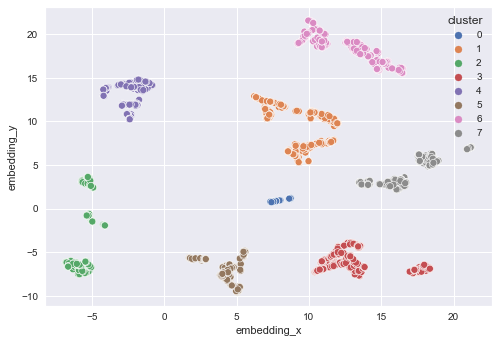

In [77]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df_cluster_embed, palette='deep')

In [78]:
# Number of customer
df_cluster = df_rfm_raw[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df_rfm_raw[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df_rfm_raw[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg products_no
df_invoice_no = df_rfm_raw[['amount_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# Frequency
df_invoice_no = df_rfm_raw[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# Returns
df_invoice_no = df_rfm_raw[['amount_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,amount_products,frequency,amount_returns
0,0,61,2.199784,911.586230,50.655738,90.131148,0.010465,0.000000
1,1,507,18.283448,2613.571972,40.893491,140.852071,0.043471,22.988166
2,2,299,10.782546,710.285819,135.749164,20.862876,0.061181,9.615385
3,3,469,16.913091,1269.629403,59.275053,57.597015,0.032730,9.027719
4,4,299,10.782546,645.280268,46.411371,14.434783,0.047573,0.963211
5,5,316,11.395600,988.198576,73.284810,37.161392,0.038813,10.952532
6,6,466,16.804904,8855.524185,21.532189,425.154506,0.088571,150.605150
7,7,356,12.838082,3002.542219,50.005618,99.896067,0.038679,19.730337


In [79]:
df_cluster.style.highlight_max(subset=['gross_revenue', 'amount_products', 'frequency'], color='lightgreen', axis=0 )\
.highlight_min(subset=['recency_days', 'amount_returns'], color='lightgreen', axis=0 )\
.highlight_max(subset=['recency_days', 'amount_returns'], color='pink', axis=0 )\
.highlight_min(subset=['gross_revenue', 'amount_products', 'frequency'], color='pink', axis=0 )

,cluster,customer_id,perc_customer,gross_revenue,recency_days,amount_products,frequency,amount_returns
0,0,61,2.199784,911.586230,50.655738,90.131148,0.010465,0.000000
1,1,507,18.283448,2613.571972,40.893491,140.852071,0.043471,22.988166
2,2,299,10.782546,710.285819,135.749164,20.862876,0.061181,9.615385
3,3,469,16.913091,1269.629403,59.275053,57.597015,0.032730,9.027719
4,4,299,10.782546,645.280268,46.411371,14.434783,0.047573,0.963211
5,5,316,11.395600,988.198576,73.284810,37.161392,0.038813,10.952532
6,6,466,16.804904,8855.524185,21.532189,425.154506,0.088571,150.605150
7,7,356,12.838082,3002.542219,50.005618,99.896067,0.038679,19.730337


Cluster A: 
- Number of customers: 466 (16.8% of customers )
- Average Recency: 21.5 days
- Average invoice_no: 425 
- Average Gross Revenue: U\$8,855.52
- Average purchases/day: 0.09
- Average products return: 150.6

Cluster B:
- Number of customers: 356 (12.8% of customers )
- Average Recency: 50 days
- Average invoice_no: 99.9
- Average Gross Revenue: U\$3,002.54
- Average purchases/day: 0.04
- Average products return: 19.7

Cluster C:
- Number of customers: 568 (20.50% of customers )
- Average Recency: 41.9 days
- Average invoice_no: 135.40 
- Average Gross Revenue: U\$2,430.80
- Average purchases/day: 0.04
- Average products return: 20.5

Cluster D:
- Number of customers: 469 (16.9% of customers )
- Average Recency: 59.27 days
- Average invoice_no: 57.6 
- Average Gross Revenue: U\$1,269.62
- Average purchases/day: 0.03
- Average products return: 9

Cluster E:
- Number of customers: 316 (11.39% of customers )
- Average Recency: 73.3 days
- Average invoice_no: 37.2 
- Average Gross Revenue: U\$988.2
- Average purchases/day: 0.03
- Average products return: 10.95

Cluster F:
- Number of customers: 147 (5.3% of customers )
- Average Recency: 78.5 days
- Average invoice_no: 27.9 
- Average Gross Revenue: U\$854.67
- Average purchases/day: 0.03
- Average products return: 3.17

Cluster G:
- Number of customers: 299 (10.78% of customers )
- Average Recency: 46.4 days
- Average invoice_no: 14.43 
- Average Gross Revenue: U\$645.28
- Average purchases/day: 0.04
- Average products return: 0.96

Cluster H:
- Number of customers: 152 (15.48% of customers )
- Average Recency: 191 days
- Average invoice_no: 14.1 
- Average Gross Revenue: U\$570.64
- Average purchases/day: 0.09
- Average products return: 15.8